In [3]:
import numpy as np
import matplotlib.pyplot as plt

# from numba import jit

from scipy.stats import norm

from scipy.stats import qmc

np.warnings.filterwarnings("ignore")

plt.style.use('Solarize_Light2')

In [4]:
seed_gen = np.random.default_rng(seed=42)

In [5]:
# Sampling methods

# @jit(nopython=True)
def random_sampling(x_range, y_range, density, seed=42):
    """
    Uses np.random.random to generate PRNGs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html
    Returns randomly sampled points within a given range
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns: 
        random_c  Array with sampled complex numbers
    """
    X = (x_range[1]-x_range[0])*np.random.random(density) + x_range[0]
    Y = (y_range[1]-y_range[0])*np.random.random(density) + y_range[0]
    random_complex = X + Y * 1j
    
    return random_complex

# @jit(nopython=True)
def latin_and_ortho(x_range, y_range, density, ortho=False, seed=42):
    """
    Latin hypercube sampling in 2 dimensions, with optional possibility for orthogonal sampling.
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns:
        random_c    Array with sampled complex numbers
    """
    # space = Space([x_range, y_range])

    # latin = Lhs(lhs_type='classic', criterion=None)
    # samples = np.asarray(latin.generate(space.dimensions, density))

    if not ortho:
        sampler = qmc.LatinHypercube(d=2, seed=seed)
    
    else:
        sampler = qmc.LatinHypercube(d=2, strength=2, seed=seed)

    sample = sampler.random(n=density)

    # Rearranging the bounds for LHC scaling
    l_bounds = np.asarray([x_range[0], y_range[0]])
    u_bounds = np.asarray([x_range[1], y_range[1]])

    sample = qmc.scale(sample, l_bounds, u_bounds)
    samples = np.asarray(sample)

    re = samples[:, 0]
    im = samples[:, 1]

    random_c = re + im * 1j

    return random_c

In [6]:
# Rejection Sampling
# @jit(nopython=True)
def rejection_sampling(x_range, y_range, C, max_iterations=150):
    """
    Estimates the area of the mandelbrot set by keeping bounded values
    and discarding diverging values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Z = np.zeros_like(C)
    T = np.zeros(C.shape)

    for i in range(max_iterations):
        M = Z.real ** 2 + Z.imag ** 2 <= 2

        Z[M] = Z[M] ** 2 + C[M]

        T[M] = i + 1

        # sub_total = np.count_nonzero(T)
        # sub_area = (sub_total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    total = np.count_nonzero(T == max_iterations)
    area = (total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area, M

In [7]:
# TEsting the sampling methods

x_range = [-2., 0.5]
y_range = [-1.5, 1.5]

sample_size =  10201 # 6241 #  #   529 
max_iterations = 100

# Sampling points
# c = complex_matrix(x_range, y_range, density=sample_size)

random_sample = random_sampling(x_range, y_range, density=sample_size)
latin_sample = latin_and_ortho(x_range, y_range, density=sample_size)
ortho_sample = latin_and_ortho(x_range, y_range, density=sample_size, ortho=True)

# Area estimation
# counted_area = rejection_sampling(x_range, y_range, c)

random_area, M_random = rejection_sampling(x_range, y_range, random_sample)
latin_area, M_latin = rejection_sampling(x_range, y_range, latin_sample)
ortho_area, M_ortho = rejection_sampling(x_range, y_range, ortho_sample)

Ms = [M_random, M_latin, M_ortho]

# print(counted_area[0])
print(random_area)
print(latin_area)
print(ortho_area)

1.568963827075777
1.5263209489265759
1.5314675031859621


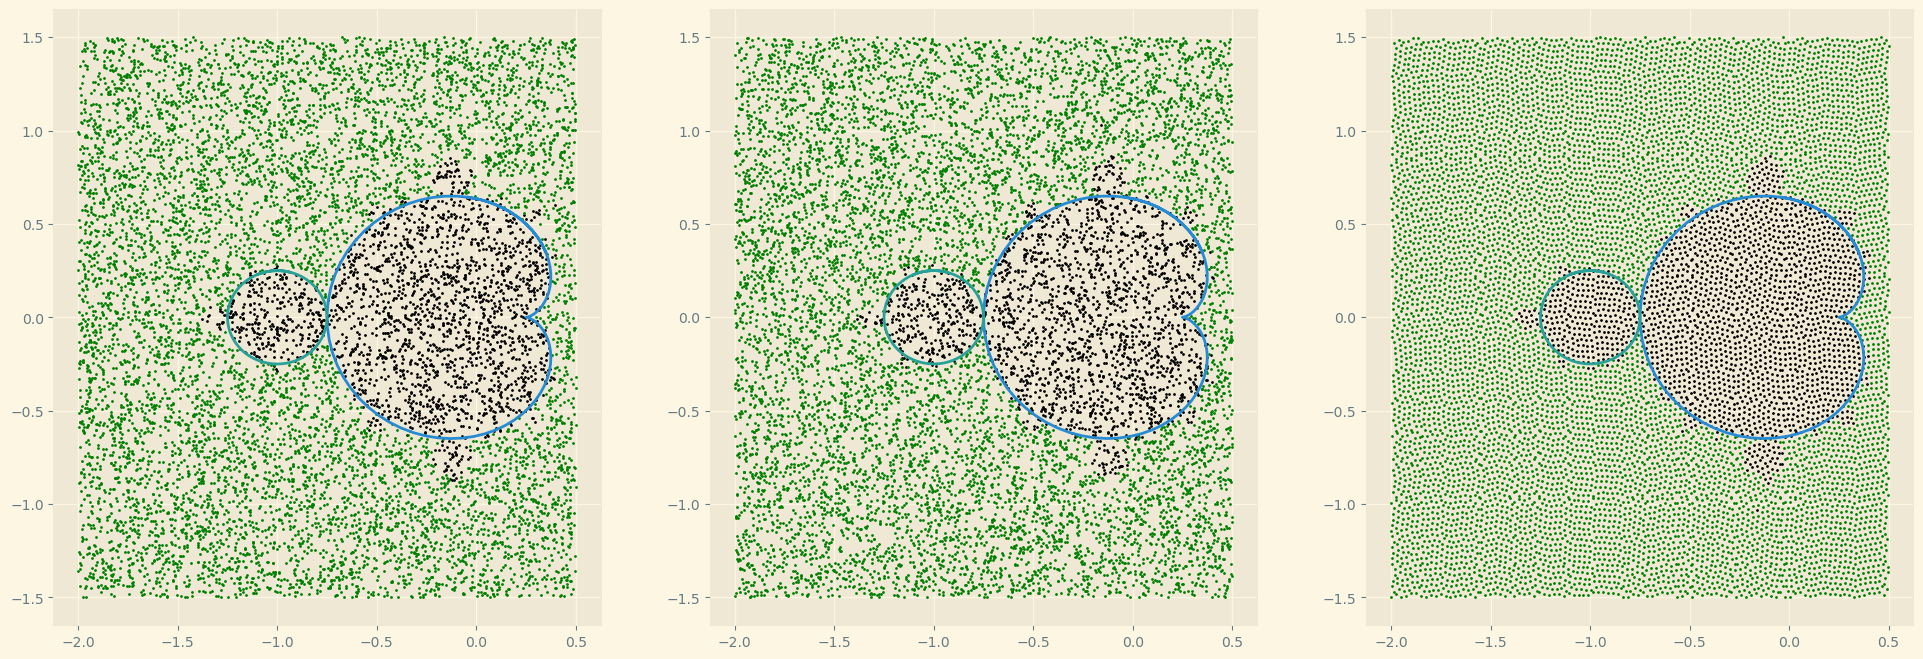

In [8]:
# PLotting
def cardioid(t):
    x = 0.5 * np.cos(t) - 0.25 * np.cos(2*t)
    y = 0.5 * np.sin(t) - 0.25 * np.sin(2*t)

    return x, y

def circle(t,r):
    x = r  * np.cos(t) - 1
    y = r * np.sin(t) 

    return x, y

t = np.linspace(-5, 2, 100)
radius = 0.25

re,im = cardioid(t)
re_c, im_c = circle(t, radius)

fig, ax = plt.subplots(1,3, figsize=(24,8))
for i, type in enumerate([random_sample, latin_sample, ortho_sample]):
    ax[i].plot([z.real for z in type[Ms[i]]], [z.imag for z in type[Ms[i]]], 'ko', markersize =1)
    ax[i].plot([z.real for z in type[~Ms[i]]], [z.imag for z in type[~Ms[i]]], 'go', markersize =1)
    ax[i].plot(re, im)
    ax[i].plot(re_c, im_c)



# Convergence Rate (Improvement)

s is the number of samples used for the area estimation, while i is the iteration count.

In [9]:
# @jit(nopython=True)
def iteration_conv(x_range, y_range, C, max_iter_count=150):
    """
    Estimates the area of the mandelbrot using a range of iteration values

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Areas = np.zeros(max_iter_count)

    for i in range(1, max_iter_count):
        area, Ms = rejection_sampling(x_range, y_range, C, max_iterations=i)
        Areas[i] = area
    
    return Areas

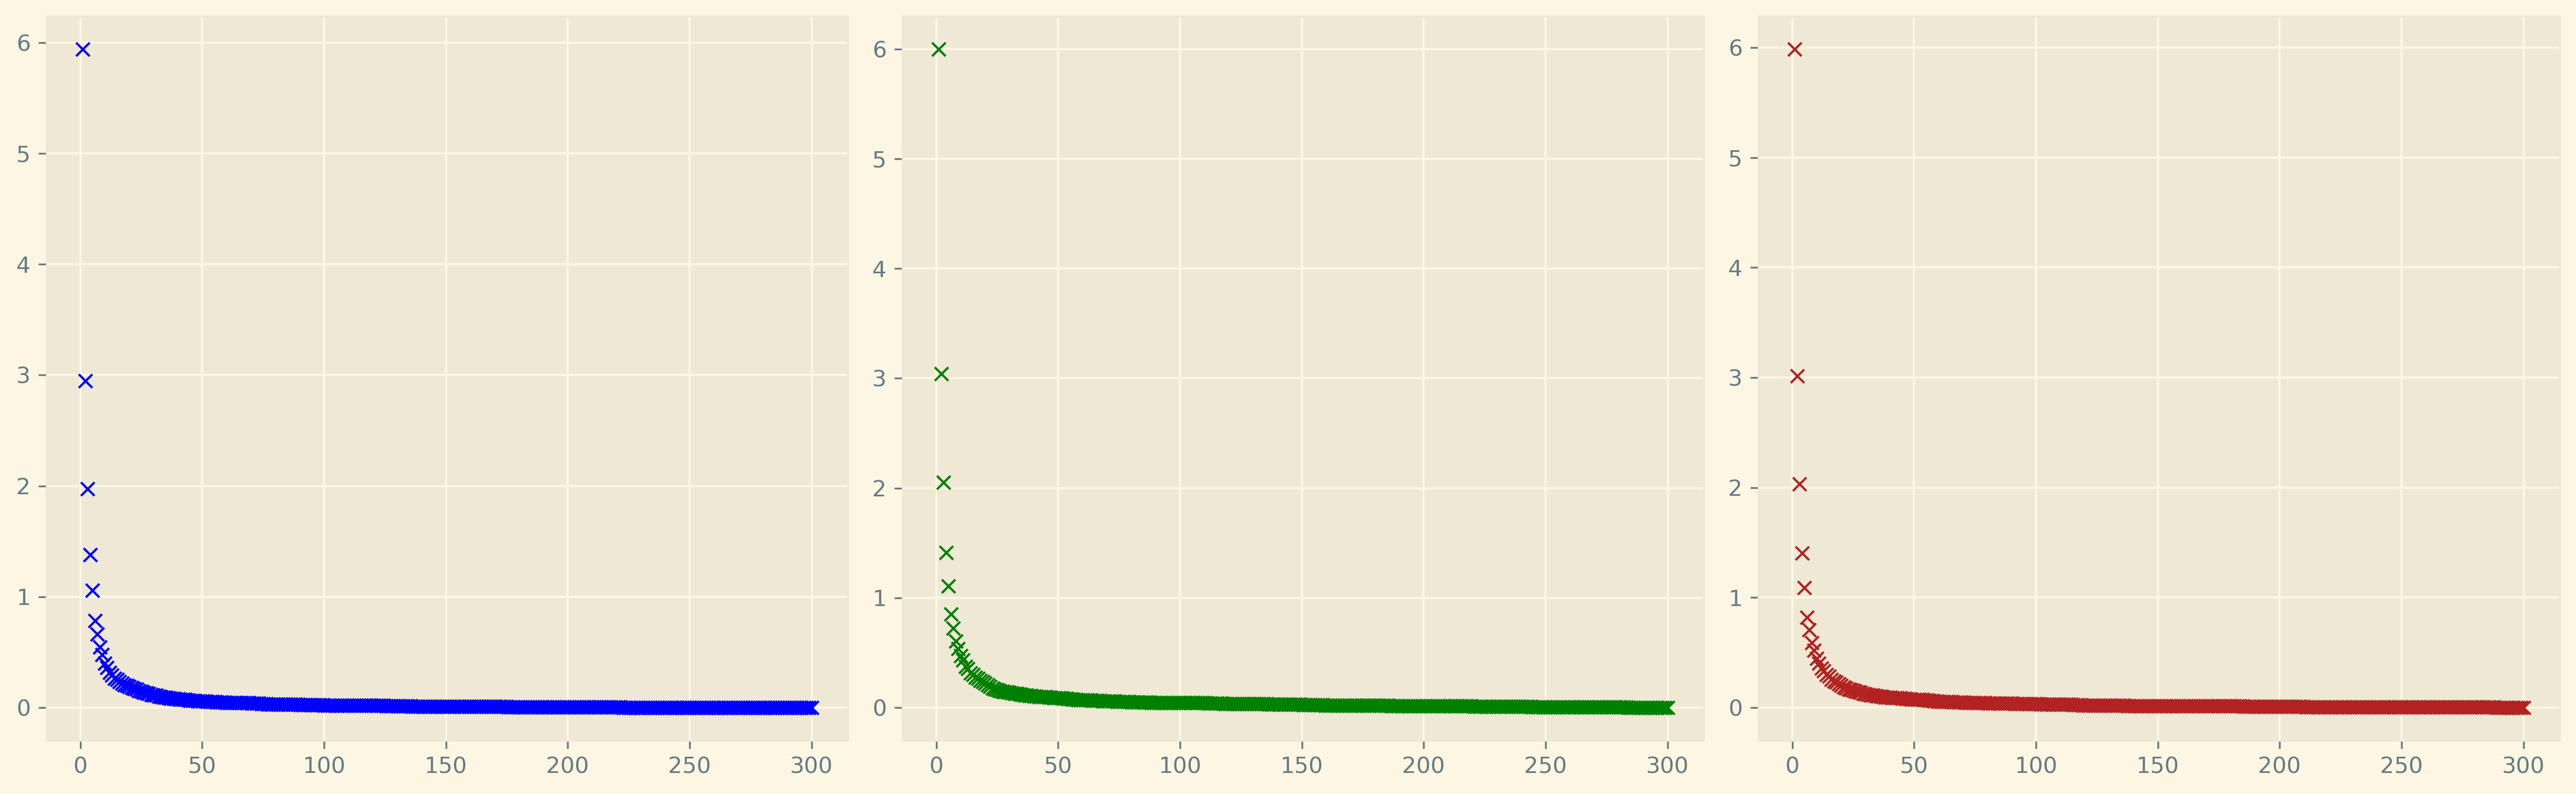

In [10]:
# Testing the functions
N_i = 300
x_i = np.linspace(1,N_i,N_i-1)

rand_areas = iteration_conv(x_range, y_range, random_sample, max_iter_count=N_i)
lhs_areas = iteration_conv(x_range, y_range, latin_sample, max_iter_count=N_i)
ortho_areas = iteration_conv(x_range, y_range, ortho_sample, max_iter_count=N_i)

converged_area = [areas[-1] for areas in [rand_areas, lhs_areas, ortho_areas]] # [rand_areas[-1], lhs_areas[-1], ortho_areas[-1]]
colors = ['blue', 'green', 'firebrick']


plt.figure(figsize=(16,5), dpi=300)
for i, type in enumerate([rand_areas, lhs_areas, ortho_areas]):
    relative_errors = [np.abs(area - converged_area[i]) for area in type]
    plt.subplot(131+i)
    plt.plot(x_i, relative_errors[1:], 'x', color=colors[i])
    
plt.tight_layout()
plt.show()

# Varying Sample Size
Next, we generate various densities for our respective sampling methods. We must adhere to using the squares of prime numbers as a density value, since the orthogonal sampling method has this as a constraint.

In [11]:
def primesfrom2to(n):
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0][1:]+1)|1)]


In [12]:
N_s = 120 # CHANGE NUMBER OF DENSITIES HERE
num_repeats = 1

primes = primesfrom2to(N_s)
density_values = primes**2

no_densities = len(primes)

rep_Areas = np.zeros((no_densities, 3)) # Areas for all sampling types at various densities, with repeated sampling for statistics

for n in range(num_repeats):
    seed = n
    Areas = np.zeros((no_densities, 3)) # Areas for all 3 sampling types at various densities

    for s, density in enumerate(density_values):
        random_sample = random_sampling(x_range, y_range, density, seed=seed)
        latin_sample= latin_and_ortho(x_range, y_range, density, seed=seed)
        ortho_sample = latin_and_ortho(x_range, y_range, density, ortho=True, seed=seed)
        for t, sample in enumerate([random_sample, latin_sample, ortho_sample]):
            Areas[s, t], M = rejection_sampling(x_range, y_range, sample, max_iterations=100)
    if not rep_Areas.any():
        rep_Areas = Areas
    else:
        rep_Areas = np.vstack((rep_Areas, Areas))

### Mean
mean_Areas = np.zeros((no_densities,3))

indeces = np.full(num_repeats, no_densities) # array of length num_repeats, filled with the number of densities
indeces = indeces * range(len(indeces)) # multiply by K*density count, with K = 0,1,2...num_repeats

for i in indeces:
    for j in range(no_densities):
        mean_Areas[j] = mean_Areas[j] +  rep_Areas[j+i]

mean_Areas = mean_Areas * 1/num_repeats

### Standard Deviation
std_Areas = np.zeros((no_densities, 3))

split_Arr = np.array_split(rep_Areas, num_repeats)

for t in range(3):
    density_stds = np.zeros(no_densities) # An array holding each density
    for i in range(no_densities):
        std_list = np.zeros(num_repeats)# create list for each density which contains all area measurements across the repeats
        for rep_num, sub_arr in enumerate(split_Arr):
            area = sub_arr[i, t]
            std_list[rep_num] = area
        std = np.std(std_list)
        density_stds[i] = std

    std_Areas[:, t] = density_stds

30


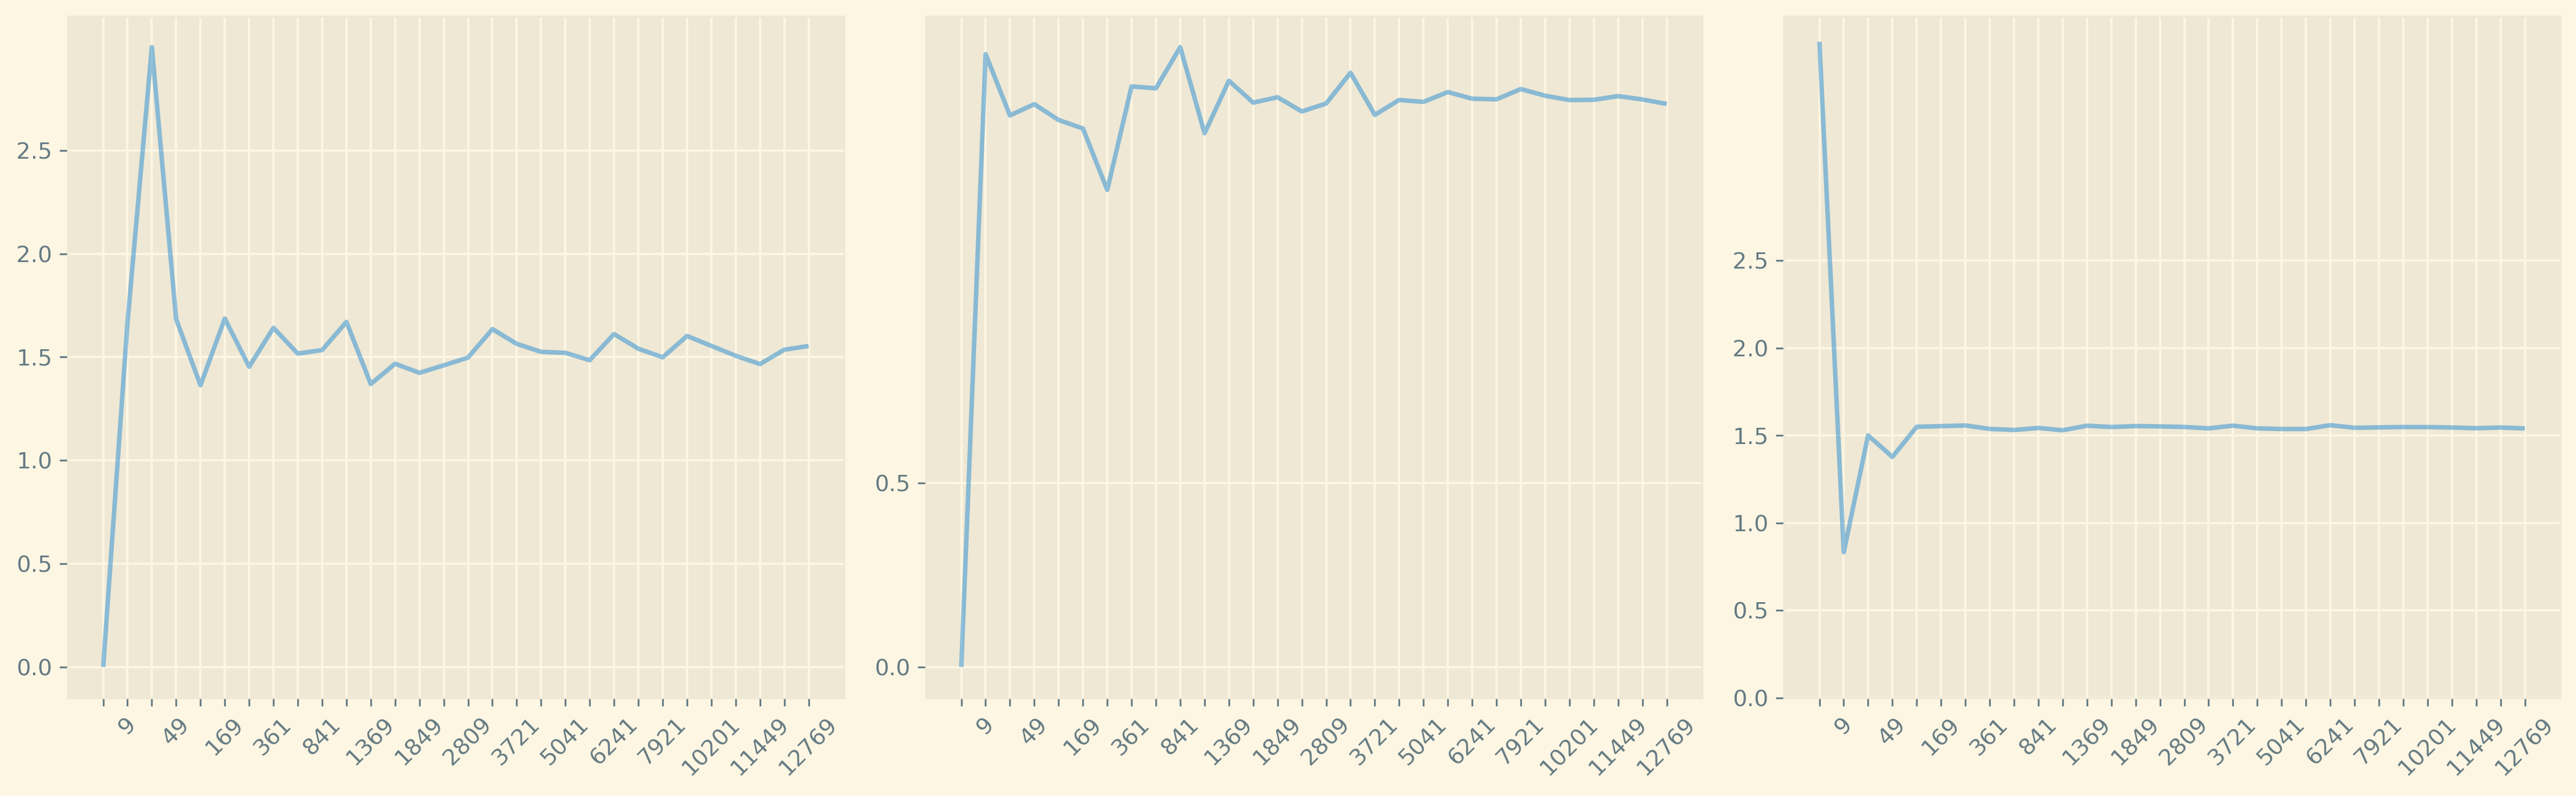

In [13]:
# x = range(len(mean_Areas[:,0])) 
x = [str(val) for val in density_values]
print(len(x))

plt.figure(figsize=(16,5), dpi=300)
for i in range(3):
    plt.subplot(131+i)
    upper = mean_Areas[:, i] + 2*std_Areas[:, i]
    lower = mean_Areas[:, i] - 2*std_Areas[:, i]
    plt.plot(x, mean_Areas[:, i], alpha=0.5)
    plt.fill_between(x, lower, upper,alpha=0.25)

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 45)

    start, end = [int(lim) for lim in ax.get_ylim()] # alternatively, plt.ylim
    ax.yaxis.set_ticks(np.arange(start, end, 0.5)) # alternatively, plt.yticks(np.arange...)

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

plt.tight_layout()
plt.show()

# Confidence Intervals

In [14]:
intervals = np.linspace(0.5, 0.999, 50)
crit_val = np.array([norm.ppf(interval + (1 - interval)/2) for interval in intervals])


# Control Variates
In order to reduce variance, we find another random variable Y that satisfies $Cov(X,Y) \neq 0$, allowing us to reduce overall variance

In [15]:
# def cardioid(t):
#     x = 0.5 * np.cos(t) - 0.25 * np.cos(2*t)
#     y = 0.5 * np.sin(t) - 0.25 * np.sin(2*t)

#     return x, y

# t = np.linspace(-5, 2, 100)

# re,im = cardioid(t)

In [16]:
# Setting Y as our control variate, which we define as the estimation of the area of the circle centered at (-1, 0) with radius 0.25
def control_variate_area(x_range, y_range, C):
    """
    Estimates the area of the mandelbrot set by keeping bounded values
    and discarding diverging values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation of the circle corresponding to orbital = 2
    """

    # Creating a Boolean Mask for Control Variate
    center_x = -1
    center_y = 0
    radius = 0.25

    mask = (C.real - center_x)**2 + (C.imag - center_y)**2 <= radius**2

    array = np.zeros(C.shape)
    array[mask] = 1

    total_control = np.count_nonzero(array)
    area_Y = (total_control/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area_Y

In [17]:
control_random_area = control_variate_area(x_range, y_range, random_sample)
control_latin_area = control_variate_area(x_range, y_range, latin_sample)
control_ortho_area = control_variate_area(x_range, y_range, ortho_sample)

In [18]:
print(control_random_area, control_latin_area, control_ortho_area)

0.19676560419766623 0.20263920432296972 0.19617824418513585


In [22]:
# def c_opt(X,Y):
#     c = -(np.cov(X,Y)/np.var(Y))

#     return c


mu_y = np.pi * 0.25**2 # expected value of our control variate

num_repeats = 5

rep_Areas = np.zeros((no_densities, 3)) # Areas for all sampling types at various densities, with repeated sampling for statistics
contr_rep_Areas = np.zeros((no_densities, 3))

for n in range(num_repeats):
    seed = n
    Areas = np.zeros((no_densities, 3)) # Areas for all 3 sampling types at various densities
    contr_Areas = np.zeros((no_densities,3))

    for s, density in enumerate(density_values):
        random_sample = random_sampling(x_range, y_range, density, seed=seed)
        latin_sample= latin_and_ortho(x_range, y_range, density, seed=seed)
        ortho_sample = latin_and_ortho(x_range, y_range, density, ortho=True, seed=seed)
        for t, sample in enumerate([random_sample, latin_sample, ortho_sample]):
            Areas[s, t], M = rejection_sampling(x_range, y_range, sample, max_iterations=100)
            contr_Areas[s,t] = control_variate_area(x_range, y_range, sample)
    if not rep_Areas.any():
        rep_Areas = Areas
        contr_rep_Areas = contr_Areas
    else:
        rep_Areas = np.vstack((rep_Areas, Areas))
        contr_rep_Areas = np.vstack((contr_rep_Areas, contr_Areas))

# indeces = np.full(num_repeats, no_densities) # array of length num_repeats, filled with the number of densities
# indeces = indeces * range(len(indeces)) # multiply by K*density count, with K = 0,1,2...num_repeats

split_Arr = np.array_split(rep_Areas, num_repeats)
split_contr = np.array_split(contr_rep_Areas, num_repeats)


mean_arr = np.zeros((no_densities, 9))
std_arr = np.zeros((no_densities, 9))


for t in range(3):
    for n in range(len(density_values)):
        X = np.zeros(num_repeats)
        Y = np.zeros(num_repeats)
        for r in range(num_repeats):
            X[r] = split_Arr[r][n][t]
            Y[r] = split_contr[r][n][t]
        S = np.cov(X,Y)
        cov_xy = S[0,1]
        var_y = S[1,1]

        c_opti = -((cov_xy) / var_y)

        transformed_X = X + c_opti * (Y - mu_y)

        mean_X = np.mean(X)
        mean_Y = np.mean(Y)
        mean_trans = np.mean(transformed_X)

        mean_arr[n,0+3*t] = mean_X
        mean_arr[n, 1+3*t] = mean_Y
        mean_arr[n, 2+3*t] = mean_trans

        std_X = np.std(X)
        std_Y = np.std(Y)
        std_trans = np.std(transformed_X)

        std_arr[n,0+3*t] = std_X
        std_arr[n, 1+3*t] = std_Y
        std_arr[n, 2+3*t] = std_trans

        print(X)
        print(f'changin?{split_Arr[r][n][t]}')
    print('TYPESWITCH')



[1.875 1.875 0.    0.    0.   ]
changin?0.0
[0.         1.66666667 1.66666667 2.5        0.        ]
changin?0.0
[0.6 0.9 0.6 1.8 0.9]
changin?0.8999999999999999
[1.83673469 0.76530612 1.07142857 1.37755102 1.37755102]
changin?1.3775510204081634
[1.30165289 1.61157025 1.98347107 1.85950413 1.67355372]
changin?1.6735537190082646
[1.50887574 1.64201183 1.68639053 1.42011834 1.73076923]
changin?1.7307692307692308
[1.32352941 1.71280277 1.47923875 1.58304498 1.58304498]
changin?1.5830449826989619
[1.53739612 1.55817175 1.55817175 1.66204986 1.66204986]
changin?1.662049861495845
[1.48865784 1.72967864 1.75803403 1.3610586  1.3610586 ]
changin?1.3610586011342156
[1.61414982 1.63198573 1.51605232 1.41795482 1.46254459]
changin?1.4625445897740785
[1.31113424 1.54526535 1.62330905 1.60770031 1.59989594]
changin?1.5998959417273673
[1.47370343 1.46274653 1.58327246 1.50657414 1.46274653]
changin?1.4627465303140978
[1.63295657 1.55710886 1.60618679 1.75342058 1.5035693 ]
changin?1.503569303985723


In [20]:
# print(split_Arr[0])
print(mean_arr)

[[3.75       0.9375     3.75       1.875      0.                nan
  3.75       0.9375     3.75      ]
 [2.08333333 0.41666667 1.42238196 1.66666667 1.25       1.66666667
  1.25       0.                nan]
 [1.5        0.                nan 1.5        0.15       1.5
  1.5        0.                nan]
 [1.68367347 0.15306122        nan 1.60714286 0.53571429 1.26777811
  1.53061224 0.22959184 1.46412765]
 [1.30165289 0.06198347        nan 1.51859504 0.15495868 1.5599859
  1.54958678 0.21694215 1.54958678]
 [1.53106509 0.17751479 1.53577378 1.55325444 0.28846154 1.67607043
  1.50887574 0.22189349        nan]
 [1.62197232 0.19463668 1.66479388 1.36245675 0.19463668 1.35960198
  1.54411765 0.19463668 1.54583051]
 [1.5166205  0.16620499 1.54676505 1.59972299 0.20775623 1.5883163
  1.49584488 0.19736842 1.49176935]
 [1.5879017  0.19139887 1.4888882  1.60916824 0.20557656 1.62454661
  1.52410208 0.19848771        nan]
 [1.48929845 0.19619501        nan 1.63644471 0.16498216 1.67478261
  1.5

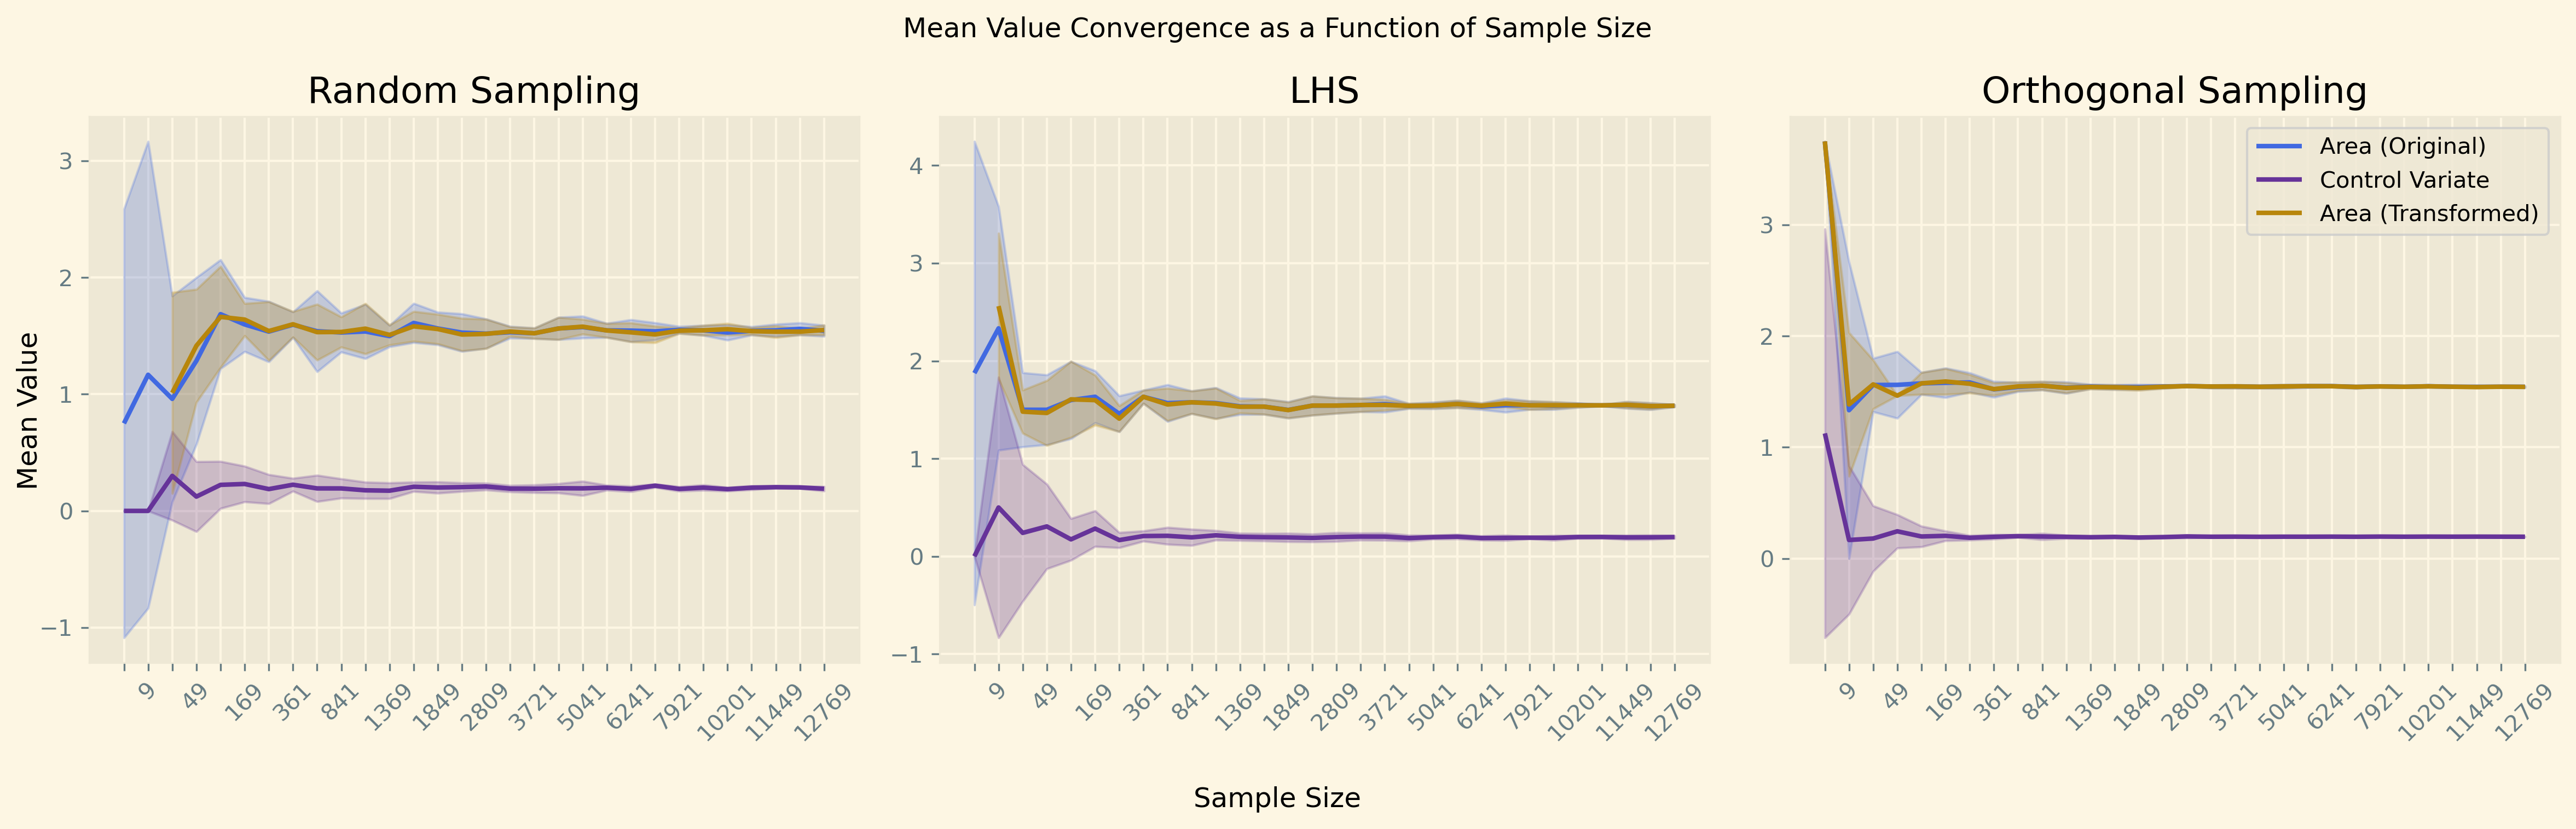

In [46]:
upper = np.zeros((no_densities, 9))
lower = np.zeros((no_densities, 9))


x = [str(val) for val in density_values]

for n in range(no_densities):
    upper[n] = mean_arr[n] + 2 * std_arr[n]
    lower[n] = mean_arr[n] - 2 * std_arr[n]

title = []

fig = plt.figure(figsize=(16,5), dpi = 300)

sampling_labels = ['Random Sampling', 'LHS', 'Orthogonal Sampling']

for t in range(3):
    plt.subplot(131+t)
    labels = ['Area (Original)', 'Control Variate', 'Area (Transformed)']
    colors = ['royalblue', 'rebeccapurple', 'darkgoldenrod']
    for var in range(3):
        plt.plot(x, mean_arr[:,var+3*t], label=labels[var],color=colors[var])
        plt.fill_between(x,lower[:, var+3*t], upper[:,var+3*t],color=colors[var],alpha=0.25)
    
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=45)

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    title = ax.set_title(sampling_labels[t], loc='center')


fig.suptitle('Mean Value Convergence as a Function of Sample Size')
fig.supxlabel('Sample Size')
fig.supylabel('Mean Value')
plt.legend()
plt.tight_layout()
plt.show()
